## Sonification of a Mars elevation map

&mdash; inspired by [SonicPhoto](http://www.skytopia.com/software/sonicphoto/).

### 1) Load the input image

The Mars elevation map is in GeoTIF format, thus it contains floating point values
outside the [0;1] range and thus must be converted first. Since loading the original
TIF takes some time, we save the normalized version to the `cache/` directory.

> *Note: The values in the GeoTIF file represent actual meters above/below mars "sea" level.*

In [1]:
import IPython.display
import tifffile
import imageio
import io
import numpy as np
import matplotlib.pyplot as plt
import os
import wave

def load_image():
  infile = 'Mars_1440x2880.tif'
  outfile = 'cache/Mars_1440x2880-normalized.tif'
  if not os.path.exists(outfile):
    # Need to use the tifffile module, as imageio seems to have problems
    # reading the TIF elevation map.
    img = tifffile.imread('Mars_1440x2880.tif')
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img = (img * 2**16-1).astype(np.uint16)
    os.makedirs('cache', exist_ok=True)
    imageio.imwrite(outfile, img)
  else:
    img = imageio.imread(outfile)
  return img

def load_jpeg(name):
  img = imageio.imread(name)
  if len(img.shape) == 3:
    img = img[:,:,0]
  return (img / 255 * (2**16-1)).astype(np.uint16)

img = load_image()
#img = load_jpeg('sound-test-01.jpg')
#img = load_jpeg('sound-test-02.jpg')

/home/niklas/jupyter/lib/python3.6/site-packages/tifffile/tifffile.py:306: UserWarning: ImportError: No module named '_tifffile'. Loading of some compressed images will be very slow. Tifffile.c can be obtained at http://www.lfd.uci.edu/~gohlke/
  "ImportError: No module named '_tifffile'. "


### 2) Helper functions for audio generation and rendering

In [2]:
def running_mean(x, N, pad=True):
  cumsum = np.cumsum(np.insert(x, 0, 0)) 
  result = (cumsum[N:] - cumsum[:-N]) / N 
  if pad:
    N -= 1
    result = np.pad(result, (N//2, (N-N//2)), 'edge')
  return result

def normalize(a):
  m = np.min(a)
  return (a - m) / (np.max(a) - m)

def render_audio(a, sample_rate):
  a = np.round(a*(2**15-1)).astype(np.int16)
  fp = io.BytesIO()
  writer = wave.open(fp, 'w')
  writer.setnchannels(1)
  writer.setframerate(sample_rate)
  writer.setsampwidth(2)
  writer.writeframes(a.tostring())
  audio = IPython.display.Audio(fp.getvalue())
  IPython.display.display(audio)

def tone(hz):
  def func(t):
    return np.sin(2.0 * np.pi * t * hz)
  return func

def superpose(a, b, aw, bw):
  def func(t):
    return a(t) * aw + b(t) * bw
  return func

def note(pitch):
  hz = 440.0 * (2.0 ** (pitch / 12.0))
  harmonics = superpose(tone(hz/2.0), tone(2.0*hz), 0.5, 0.5)
  return superpose(harmonics, tone(hz), 0.5, 0.5)

### 3) Convert the image into sound

Generating audio signal
Generating plot
Rendering audio


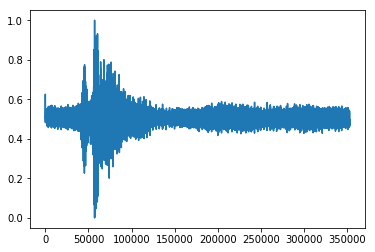

In [3]:
def compile_interp(dest_count, source_count):
  x = np.linspace(0, 1, dest_count)
  xp = np.linspace(0, 1, source_count)
  def interp(*args, **kwargs):
    return np.interp(x, xp, *args, **kwargs)
  return interp

def image_to_amplitudes(img, n):
  """
  Samples brightness values along the horizontal axis of *img* with a
  resolution of *n* samples per column, yielding an array of *n* rows
  and *m* columns where *m* is the original number of columns in *img*.
  """

  amps = []
  for col in img.T:
    col = np.interp(np.linspace(0, 1, n), np.linspace(0, 1, len(col)), col)
    amps.append(col)
  return np.array(amps).T


def image_to_audio(img, freqs, duration, sample_rate=44100, amp_power=4):
  """
  Generate an audio signal from *img* and the frequencies *freqs*. *freqs* must
  be a list of callables that yield a signal over a time-array (eg #tone() or
  #note()).
  """

  nframes = int(round(sample_rate * duration))  
  phase = np.zeros_like(freqs)
  amps = image_to_amplitudes(img, len(freqs))
  amps_resample = compile_interp(nframes, amps.shape[1])
  
  t = np.linspace(0, nframes / sample_rate, nframes)  # Don't use #duration!
  signal = np.zeros(nframes)
  for i in range(len(freqs)):
    signal += freqs[i](t) * amps_resample(amps[i] ** amp_power)
  return normalize(signal)

print('Generating audio signal')
sample_rate = 44100
signal = image_to_audio(
  img = img,
  freqs = [note(30-i-15) for i in range(30)],
  duration = 8.0,
  sample_rate = sample_rate
)

print('Generating plot')
plt.plot(signal)
  
print('Rendering audio')
render_audio(signal, sample_rate)
plt.show()